<a href="https://colab.research.google.com/github/thuyk39nguyen/AIO/blob/main/modul5_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.Bài toán 1: Dự đoán hiệu suất xe hơi.**

In [ ]:
! gdown --id 1 qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY] [--speed SPEED]
             [--no-cookies] [--no-check-certificate] [--continue] [--folder] [--remaining-ok]
             [--format FORMAT] [--user-agent USER_AGENT]
             url_or_id
gdown: error: unrecognized arguments: qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
  torch.cuda.manual_seed(random_state)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)

In [ ]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Europe        392 non-null    int64  
 8   Japan         392 non-null    int64  
 9   USA           392 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 30.8 KB


In [ ]:
X = dataset.drop(columns ='MPG').values
y = dataset ['MPG'].values

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y,test_size = val_size, random_state = random_state, shuffle = is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,test_size = test_size, random_state = random_state,shuffle = is_shuffle)

In [ ]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[ idx ], self.y[ idx ]

In [ ]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    x = F.relu(x)
    out = self.output(x)
    return out.squeeze(1)

In [ ]:
input_dims = X_train.shape [1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims = input_dims, hidden_dims = hidden_dims, output_dims = output_dims).to(device)

In [ ]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
def r_squared(y_true, y_pred):
  y_true = torch.Tensor(y_true).to(device)
  y_pred = torch.Tensor(y_pred).to(device)
  mean_true = torch.mean(y_true)
  ss_tot = torch.sum((y_true - mean_true) ** 2)
  ss_res = torch.sum((y_true - y_pred) ** 2)
  r2 = 1 -(ss_res / ss_tot)
  return r2

Huấn luyện mô hình

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []
for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  val_target = []
  train_predict = []
  val_predict = []
  model.train()
  for X_samples, y_samples in train_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    optimizer.zero_grad()
    outputs = model(X_samples)
    train_predict += outputs.tolist()
    train_target += y_samples.tolist()
    loss = criterion(outputs, y_samples)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_r2.append(r_squared(train_target, train_predict))
  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for X_samples, y_samples in val_loader:
      X_samples = X_samples.to(device)
      y_samples = y_samples.to(device)
      outputs = model(X_samples)
      val_predict += outputs.tolist()
      val_target += y_samples.tolist()
      loss = criterion(outputs, y_samples)
      val_loss += loss.item()
  val_loss /= len(val_loader)
  val_losses.append(val_loss)
  val_r2.append(r_squared(val_target, val_predict))
  print(f'\ nEPOCH{epoch + 1}:\ tTraining loss:{train_loss:.3f}\tValidation loss:{val_loss:.3f}')

\ nEPOCH 1:\ tTraining loss : 282.769	Validation loss : 88.672
\ nEPOCH 2:\ tTraining loss : 137.669	Validation loss : 72.346
\ nEPOCH 3:\ tTraining loss : 71.007	Validation loss : 19.143
\ nEPOCH 4:\ tTraining loss : 25.083	Validation loss : 196.176
\ nEPOCH 5:\ tTraining loss : 96.139	Validation loss : 20.444
\ nEPOCH 6:\ tTraining loss : 17.765	Validation loss : 9.444
\ nEPOCH 7:\ tTraining loss : 18.486	Validation loss : 14.535
\ nEPOCH 8:\ tTraining loss : 37.859	Validation loss : 37.427
\ nEPOCH 9:\ tTraining loss : 17.133	Validation loss : 38.134
\ nEPOCH 10:\ tTraining loss : 22.991	Validation loss : 41.183
\ nEPOCH 11:\ tTraining loss : 26.723	Validation loss : 20.063
\ nEPOCH 12:\ tTraining loss : 9.852	Validation loss : 5.594
\ nEPOCH 13:\ tTraining loss : 15.143	Validation loss : 16.025
\ nEPOCH 14:\ tTraining loss : 12.213	Validation loss : 12.023
\ nEPOCH 15:\ tTraining loss : 14.222	Validation loss : 7.731
\ nEPOCH 16:\ tTraining loss : 10.845	Validation loss : 18.904
\ 

In [ ]:
model.eval()
with torch.no_grad():
  y_hat = model(X_test)
  test_set_r2 = r_squared(y_hat, y_test)
  print('Evaluation on test set:')
  print(f'R2:{test_set_r2}')

Evaluation on test set :
R2: 0.8417800068855286


## **Bài toán 2: Phân loại với dữ liệu phi tuyến:**

In [ ]:
! gdown --id 1 SqSn_8rxkk - Qvu4JLMcN_3ZFGDNa6P_V

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY] [--speed SPEED]
             [--no-cookies] [--no-check-certificate] [--continue] [--folder] [--remaining-ok]
             [--format FORMAT] [--user-agent USER_AGENT]
             url_or_id
gdown: error: unrecognized arguments: SqSn_8rxkk - Qvu4JLMcN_3ZFGDNa6P_V


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch .nn as nn
import torch .nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
device = torch.device ('cuda:0' if torch.cuda.is_available () else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available ():
  torch.cuda.manual_seed(random_state)

In [ ]:
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle = True).item ()
X, y = data ['X'], data ['labels']
print (X.shape, y.shape)

(300, 2) (300,)


Chia tệp train test val

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split (X, y, test_size = val_size, random_state = random_state, shuffle = is_shuffle)

X_train, X_test, y_train, y_test = train_test_split (X_train, y_train, test_size = test_size, random_state = random_state, shuffle = is_shuffle)

Chuẩn hóa dữ liệu đầu vào

In [ ]:
normalizer = StandardScaler ()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor (X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
y_val = torch.tensor (y_val, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)

Xây dựng DataLoader:

In [ ]:
class CustomDataset(Dataset):
  def __init__ (self, X, y):
    self .X = X
    self .y = y

  def __len__(self):
    return len(self .y)
  def __getitem__ (self, idx):
    return self .X[ idx ], self .y[ idx ]

In [ ]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset (X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

Xây dựng mạng MLP:

In [ ]:
class MLP (nn.Module):
  def __init__ (self, input_dims, hidden_dims, output_dims):
    super (MLP, self).__init__ ()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)
    self.relu = nn.ReLU ()

  def forward (self, x):
    x = self.linear1 (x)
    x = self.relu (x)
    out = self.output (x)
    return out.squeeze (1)

In [ ]:
input_dims = X_train.shape [1]
output_dims = torch.unique(y_train).shape [0]
hidden_dims = 128

model = MLP(input_dims = input_dims, hidden_dims = hidden_dims, output_dims = output_dims) .to( device)

Khai báo hàm loss và optimizer:

In [ ]:
lr = 1e-1
criterion = nn.CrossEntropyLoss ()
optimizer = torch.optim.SGD(model.parameters (), lr=lr)

Xây dựng hàm tính độ chính xác:

In [ ]:
def compute_accuracy (y_hat, y_true):
  _, y_hat = torch.max (y_hat, dim =1)
  correct =(y_hat == y_true).sum ().item ()
  accuracy = correct
  return accuracy

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  train_predict = []
  model.train ()
  for X_samples, y_samples in train_loader:
    X_samples = X_samples .to( device)
    y_samples = y_samples .to( device)
    optimizer.zero_grad ()
    outputs = model(X_samples)
    loss = criterion(outputs, y_samples)
    loss.backward ()
    optimizer.step ()
    train_loss += loss.item ()

    train_predict.append(outputs.detach ().cpu ())
    train_target.append(y_samples.cpu ())

  train_loss /= len( train_loader)
  train_losses.append(train_loss)

  train_predict = torch.cat(train_predict)
  train_target = torch.cat(train_target)
  train_acc = compute_accuracy(train_predict, train_target)
  train_accs.append(train_acc)

  val_loss = 0.0
  val_target = []
  val_predict = []
  model.eval ()
  with torch.no_grad ():
    for X_samples, y_samples in val_loader:
      X_samples = X_samples .to( device)
      y_samples = y_samples .to( device)
      outputs = model(X_samples)
      val_loss += criterion(outputs, y_samples).item ()

      val_predict.append(outputs.cpu ())
      val_target.append(y_samples.cpu ())

  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  val_predict = torch.cat(val_predict)
  val_target = torch.cat(val_target)
  val_acc = compute_accuracy(val_predict, val_target)
  val_accs.append(val_acc)

  print (f'\nEPOCH{epoch + 1}:\ tTraining loss:{train_loss:.3f}\tValidation loss:{val_loss:.3f}')


EPOCH 1:\ tTraining loss : 0.917	Validation loss : 0.840

EPOCH 2:\ tTraining loss : 0.746	Validation loss : 0.795

EPOCH 3:\ tTraining loss : 0.707	Validation loss : 0.773

EPOCH 4:\ tTraining loss : 0.688	Validation loss : 0.762

EPOCH 5:\ tTraining loss : 0.663	Validation loss : 0.750

EPOCH 6:\ tTraining loss : 0.637	Validation loss : 0.718

EPOCH 7:\ tTraining loss : 0.618	Validation loss : 0.702

EPOCH 8:\ tTraining loss : 0.614	Validation loss : 0.686

EPOCH 9:\ tTraining loss : 0.606	Validation loss : 0.668

EPOCH 10:\ tTraining loss : 0.578	Validation loss : 0.655

EPOCH 11:\ tTraining loss : 0.566	Validation loss : 0.639

EPOCH 12:\ tTraining loss : 0.545	Validation loss : 0.626

EPOCH 13:\ tTraining loss : 0.540	Validation loss : 0.623

EPOCH 14:\ tTraining loss : 0.537	Validation loss : 0.610

EPOCH 15:\ tTraining loss : 0.521	Validation loss : 0.585

EPOCH 16:\ tTraining loss : 0.517	Validation loss : 0.565

EPOCH 17:\ tTraining loss : 0.495	Validation loss : 0.555

EPOCH

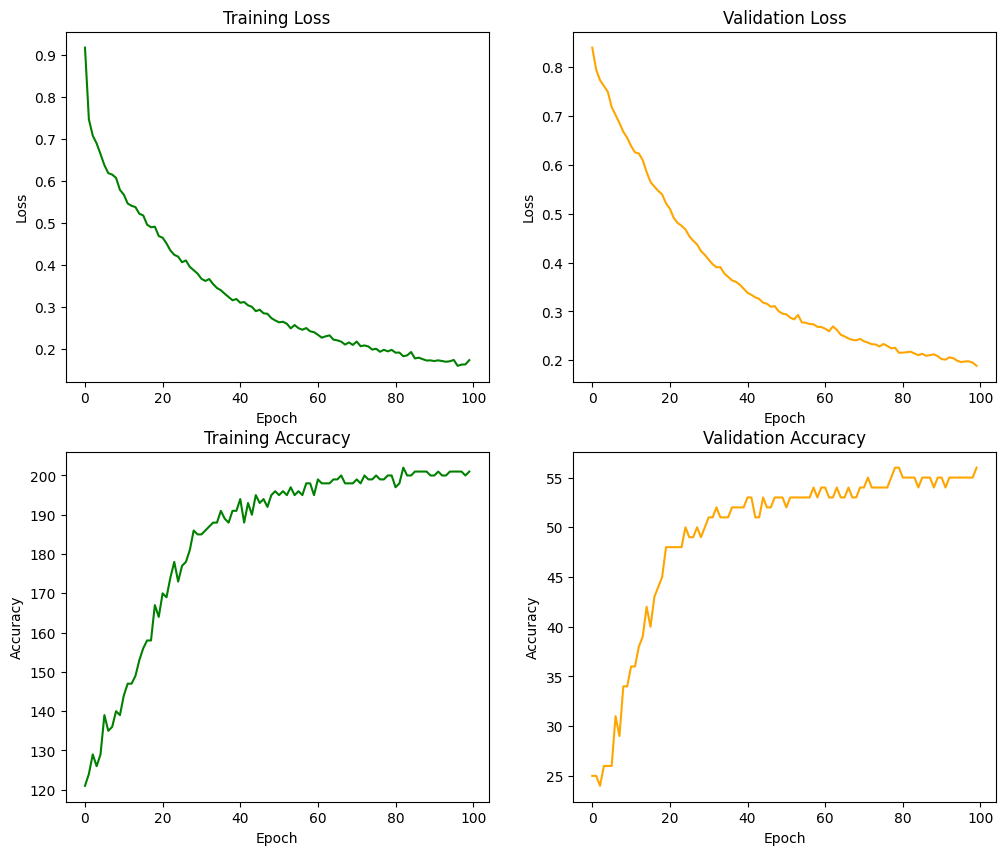

In [ ]:
fig, ax = plt.subplots (2, 2, figsize =(12, 10))
ax [0, 0].plot(train_losses, color ='green')
ax [0, 0].set(xlabel ='Epoch', ylabel ='Loss')
ax [0, 0].set_title ('Training Loss')

ax [0, 1].plot(val_losses, color ='orange')
ax [0, 1].set(xlabel ='Epoch', ylabel ='Loss')
ax [0, 1].set_title ('Validation Loss')

ax [1, 0].plot(train_accs, color ='green')
ax [1, 0].set(xlabel ='Epoch', ylabel ='Accuracy')
ax [1, 0].set_title ('Training Accuracy')

ax [1, 1].plot(val_accs, color ='orange')
ax [1, 1].set(xlabel ='Epoch', ylabel ='Accuracy')
ax [1, 1].set_title ('Validation Accuracy')
plt.show ()

Đánh giá mô hình

In [ ]:
test_target = []
test_predict = []
model.eval ()
with torch.no_grad ():
  for X_samples, y_samples in test_loader:
    X_samples = X_samples .to( device)
    y_samples = y_samples .to( device)
    outputs = model(X_samples)

    test_predict.append(outputs.cpu ())
    test_target.append(y_samples.cpu ())

  test_predict = torch.cat(test_predict)
  test_target = torch.cat(test_target)
  test_acc = compute_accuracy(test_predict, test_target)

  print ('Evaluation on test set:')
  print (f'Accuracy:{ test_acc}')

Evaluation on test set:
Accuracy : 28


## **Bài toán 3: Phân loại cảm xúc trên ảnh.**

In [ ]:
! unzip -q '/content/FER-2013.zip'

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch .nn as nn
import torch .nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision .io import read_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán:

In [ ]:
device = torch.device ('cuda:0' if torch.cuda.is_available () else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available ():
  torch.cuda.manual_seed(random_state)

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx ={ cls:idx for idx, cls in enumerate(classes)}
idx2label ={ idx:cls for cls, idx in label2idx.items ()}

Xây dựng DataLoader:

In [ ]:
test_img_path ='/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print (f'Image height:{img_height}')
print (f'Image width:{img_width}')

Image height:128
Image width:128


In [ ]:
class ImageDataset(Dataset):
  def __init__ (self, img_dir, norm, label2idx, split ='train', train_ratio =0.8):
    self.resize = Resize (( img_height, img_width))
    self.norm = norm
    self.split = split
    self.train_ratio = train_ratio
    self.img_dir = img_dir
    self.label2idx = label2idx
    self.img_paths, self.img_labels = self.read_img_files ()

    if split in ['train','val'] and'train' in img_dir.lower ():
      train_data, val_data = train_test_split (list(zip(self.img_paths, self.img_labels)), train_size = train_ratio, random_state = random_state, stratify = self.img_labels)

      if split =='train':
        self.img_paths, self.img_labels = zip (* train_data)
      elif split =='val':
        self.img_paths, self.img_labels = zip (* val_data)

  def read_img_files(self):
    img_paths = []
    img_labels = []
    for cls in self.label2idx.keys ():
      for img in os.listdir (os.path.join(self.img_dir, cls)):
        img_paths.append (os.path.join(self.img_dir, cls, img))
        img_labels.append(cls)

    return img_paths, img_labels

  def __len__(self):
    return len(self.img_paths)

  def __getitem__ (self, idx):
    img_path = self.img_paths [ idx ]
    cls = self.img_labels [ idx ]
    img = self.resize(read_image(img_path))
    img = img.type(torch.float32)
    label = self.label2idx [ cls ]
    if self.norm:
      img =(img /127.5) - 1
    return img, label


Sau đó, DataLoader được khởi tạo cho các tập train, val, và test với batch size là 256.

In [ ]:
batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, split ='train')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

val_dataset = ImageDataset(train_dir, True, label2idx, split ='val')
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

test_dataset = ImageDataset(test_dir, True, label2idx, split ='test')
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

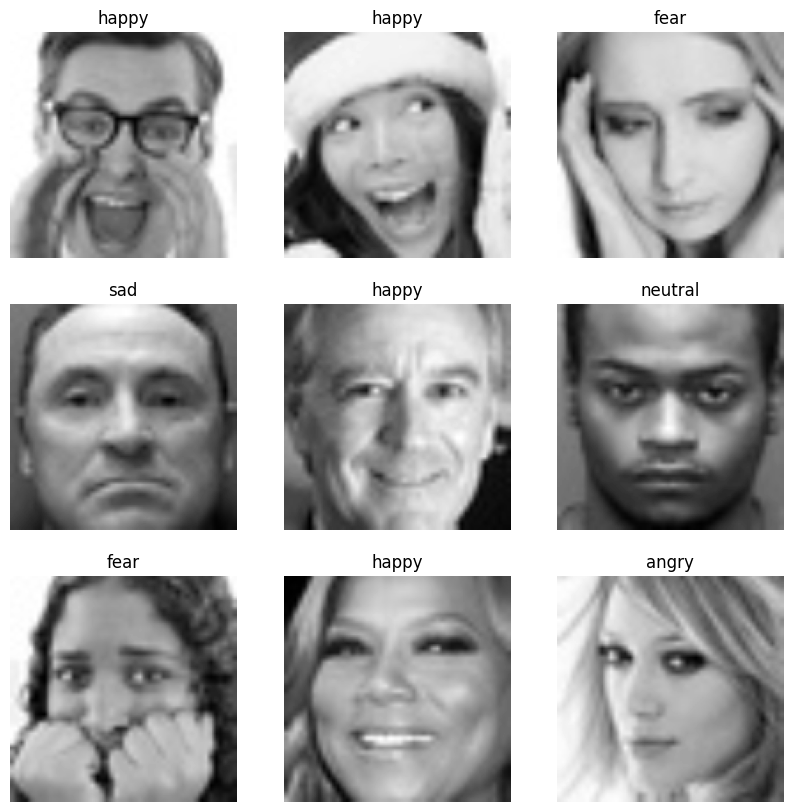

In [ ]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize =(10, 10))
for i in range (9) :
  ax = plt.subplot (3, 3, i + 1)
  minv = image_batch [i].numpy ().min ()
  maxv = image_batch [i].numpy ().max ()
  plt.imshow (np.squeeze(image_batch [i].numpy ()), vmin =minv, vmax =maxv, cmap ="gray")
  label = label_batch [i]
  plt.title(idx2label [ label.item () ])
  plt.axis ("off")

In [ ]:
class MLP (nn.Module):
  def __init__ (self, input_dims, hidden_dims, output_dims):
    super (MLP, self).__init__ ()
    self.linear1 = nn.Linear(input_dims, hidden_dims *4)
    self.linear2 = nn.Linear(hidden_dims *4, hidden_dims *2)
    self.linear3 = nn.Linear(hidden_dims *2, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward (self, x) :
    x = nn.Flatten () (x)
    x = self.linear1 (x)
    x = F.relu (x)
    x = self.linear2 (x)
    x = F.relu (x)
    x = self.linear3 (x)
    x = F.relu (x)
    out = self.output (x)
    return out.squeeze (1)

input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims = input_dims, hidden_dims = hidden_dims, output_dims = output_dims).to( device)

In [ ]:
criterion = nn.CrossEntropyLoss ()
optimizer = torch.optim.SGD(model.parameters (), lr=lr)

In [ ]:
def compute_accuracy (y_hat, y_true):
  _, y_hat = torch.max (y_hat, dim =1)
  correct = (y_hat == y_true).sum ().item ()
  accuracy = correct/len (y_true)
  return accuracy

In [ ]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  train_predict = []
  model.train ()
  for X_samples, y_samples in train_loader :
    X_samples = X_samples .to( device)
    y_samples = y_samples .to( device)
    optimizer.zero_grad ()
    outputs = model( X_samples)
    loss = criterion(outputs, y_samples)
    loss.backward ()
    optimizer.step ()
    train_loss += loss.item ()

    train_predict.append(outputs.detach ().cpu ())
    train_target.append(y_samples.cpu ())

  train_loss /= len( train_loader)
  train_losses.append(train_loss)

  train_predict = torch.cat(train_predict)
  train_target = torch.cat(train_target)
  train_acc = compute_accuracy(train_predict, train_target)
  train_accs.append(train_acc)

  val_loss = 0.0
  val_target = []
  val_predict = []
  model.eval ()
  with torch.no_grad () :
    for X_samples, y_samples in val_loader :
      X_samples = X_samples .to( device)
      y_samples = y_samples .to( device)
      outputs = model(X_samples)
      val_loss += criterion(outputs, y_samples).item ()

      val_predict.append(outputs.cpu ())
      val_target.append(y_samples.cpu ())

  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  val_predict = torch.cat(val_predict)
  val_target = torch.cat(val_target)
  val_acc = compute_accuracy(val_predict, val_target)
  val_accs.append(val_acc)

  print (f'\nEPOCH {epoch + 1}:\ tTraining loss : {train_loss :.3f}\tValidation loss : {val_loss :.3f}')


EPOCH 1:\ tTraining loss : 1.907	Validation loss : 1.868

EPOCH 2:\ tTraining loss : 1.837	Validation loss : 1.820

EPOCH 3:\ tTraining loss : 1.804	Validation loss : 1.799

EPOCH 4:\ tTraining loss : 1.785	Validation loss : 1.783

EPOCH 5:\ tTraining loss : 1.770	Validation loss : 1.768

EPOCH 6:\ tTraining loss : 1.753	Validation loss : 1.751

EPOCH 7:\ tTraining loss : 1.734	Validation loss : 1.731

EPOCH 8:\ tTraining loss : 1.713	Validation loss : 1.710

EPOCH 9:\ tTraining loss : 1.692	Validation loss : 1.690

EPOCH 10:\ tTraining loss : 1.672	Validation loss : 1.671

EPOCH 11:\ tTraining loss : 1.655	Validation loss : 1.657

EPOCH 12:\ tTraining loss : 1.641	Validation loss : 1.648

EPOCH 13:\ tTraining loss : 1.631	Validation loss : 1.638

EPOCH 14:\ tTraining loss : 1.620	Validation loss : 1.631

EPOCH 15:\ tTraining loss : 1.611	Validation loss : 1.625

EPOCH 16:\ tTraining loss : 1.602	Validation loss : 1.619

EPOCH 17:\ tTraining loss : 1.594	Validation loss : 1.613

EPOCH

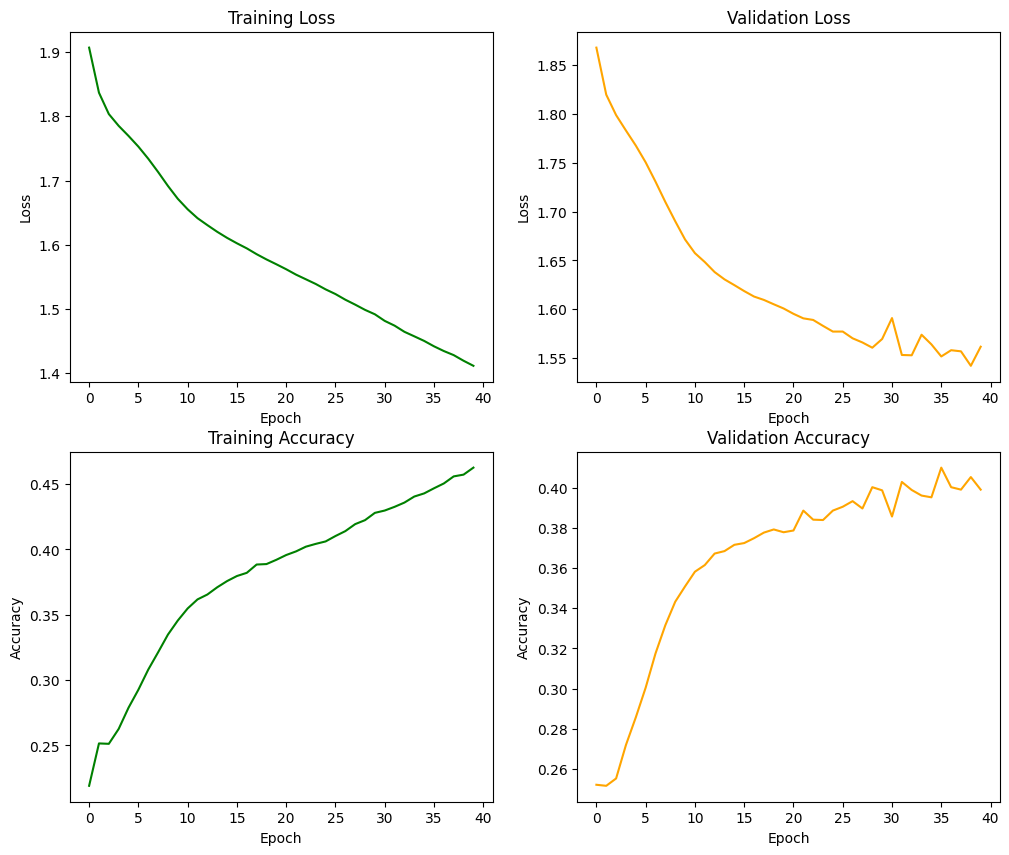

In [ ]:
fig, ax = plt.subplots (2, 2, figsize =(12, 10))
ax [0, 0].plot(train_losses, color ='green')
ax [0, 0].set(xlabel ='Epoch', ylabel ='Loss')
ax [0, 0].set_title ('Training Loss')

ax [0, 1].plot(val_losses, color ='orange')
ax [0, 1].set(xlabel ='Epoch', ylabel ='Loss')
ax [0, 1].set_title ('Validation Loss')

ax [1, 0].plot(train_accs, color ='green')
ax [1, 0].set(xlabel ='Epoch', ylabel ='Accuracy')
ax [1, 0].set_title ('Training Accuracy')
ax [1, 1].plot(val_accs, color ='orange')
ax [1, 1].set(xlabel ='Epoch', ylabel ='Accuracy')
ax [1, 1].set_title ('Validation Accuracy')

plt.show ()

Đánh giá mô hình:

In [ ]:
test_target = []
test_predict = []
model.eval ()
with torch.no_grad () :
  for X_samples, y_samples in test_loader :
    X_samples = X_samples .to( device)
    y_samples = y_samples .to( device)
    outputs = model(X_samples)

    test_predict.append(outputs.cpu ())
    test_target.append(y_samples.cpu ())

  test_predict = torch.cat(test_predict)
  test_target = torch.cat(test_target)
  val_acc = compute_accuracy(test_predict, test_target)

  print ('Evaluation on test set :')
  print (f'Accuracy : {val_acc}')

Evaluation on test set :
Accuracy : 0.40192254109779885
